In [1]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator, Aer
import networkx as nx
import numpy as np
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

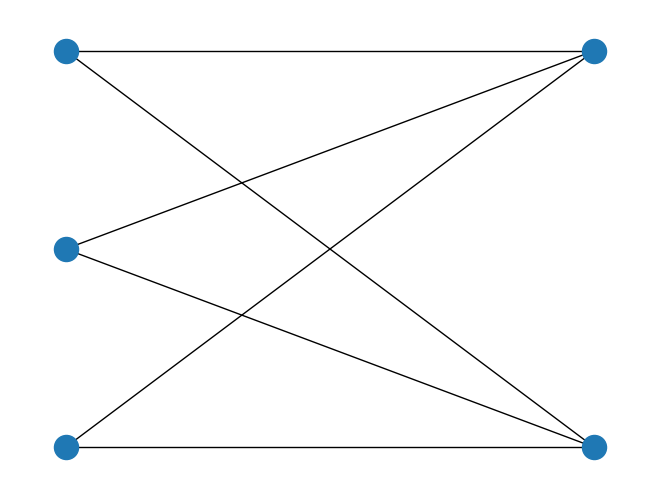

In [2]:
G = nx.Graph()
edges = [[0,3], [0,4], [1,3], [1,4], [2,3], [2,4]]
G.add_edges_from(edges)

nx.draw(G, pos = nx.bipartite_layout(G, [0,1,2]))

In [3]:
def append_zz(qc, q1, q2, gamma):
    qc.cx(q1, q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1, q2)

def build_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N, N)
    
    return qc

In [4]:
qc = build_cost_operator_circuit(G, np.pi/3)
qc.draw()

q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
c: 5/

In [5]:
def append_x(qc, q1, beta):
    qc.rx(2*beta, q1)

def build_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x(qc, n, beta)
    return qc

In [6]:
qc = build_mixer_operator_circuit(G, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ Rx(2π/3) ├
     ├──────────┤
q_1: ┤ Rx(2π/3) ├
     ├──────────┤
q_2: ┤ Rx(2π/3) ├
     ├──────────┤
q_3: ┤ Rx(2π/3) ├
     ├──────────┤
q_4: ┤ Rx(2π/3) ├
     └──────────┘
c: 5/════════════

In [7]:
def build_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)

    qc.h(range(N))

    for i in range(p):
        qc.barrier()
        for j, k in G.edges():
            append_zz(qc, j, k, gamma[i])
        qc.barrier()
        for n in G.nodes():
            append_x(qc, n, beta[i])

    qc.measure(range(N), range(N))
    return qc
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [8]:
def no_of_cuts(x, G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            cut += 1
    return cut

In [11]:
def compute_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        cuts = no_of_cuts(meas, G)
        energy += -1 * cuts * meas_count
        total_counts += meas_count
    return energy / total_counts

In [12]:
def black_box_obj(G, p):
    simulator = AerSimulator(method="statevector", device="GPU")
    def f(theta):
        beta = theta[:p]
        gamma = theta[p:]
        qc = build_qaoa_circuit(G, beta, gamma)
        counts = simulator.run(qc, shots=1024).result().get_counts()

        return compute_energy(invert_counts(counts), G)
    return f

In [13]:
p = 5
obj = black_box_obj(G, p)
init_point = np.array([0.8, 2.2, 0.3,2.1,0.3,2.4,6.1,2.2,3.8,6.1])
sample = minimize(obj, init_point, method='COBYLA', options={'maxiter': 2500, 'disp': True})
sample

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.8740234375
       x: [ 1.805e+00  2.341e+00  3.180e-01  2.379e+00  1.069e-01
            2.462e+00  6.085e+00  2.157e+00  3.648e+00  6.118e+00]
    nfev: 120
   maxcv: 0.0


   Normal return from subroutine COBYLA

   NFVALS =  120   F =-5.874023E+00    MAXCV = 0.000000E+00
   X = 1.804885E+00   2.340715E+00   3.180330E-01   2.378704E+00   1.068979E-01
       2.461801E+00   6.084522E+00   2.157199E+00   3.647620E+00   6.118480E+00


In [16]:
simulator = AerSimulator(method="statevector", device="GPU")
optimal_theta = sample['x']
qc = build_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(simulator.run(qc, shots=1024).result().get_counts())
counts

{'01110': 1,
 '11010': 1,
 '11001': 3,
 '10011': 2,
 '11110': 1,
 '01010': 3,
 '11100': 493,
 '11000': 2,
 '00110': 2,
 '01100': 3,
 '00010': 1,
 '10110': 2,
 '10100': 1,
 '10001': 1,
 '10010': 2,
 '01011': 3,
 '00001': 5,
 '00011': 481,
 '11111': 6,
 '00000': 3,
 '01001': 2,
 '00111': 2,
 '10101': 1,
 '11101': 3}

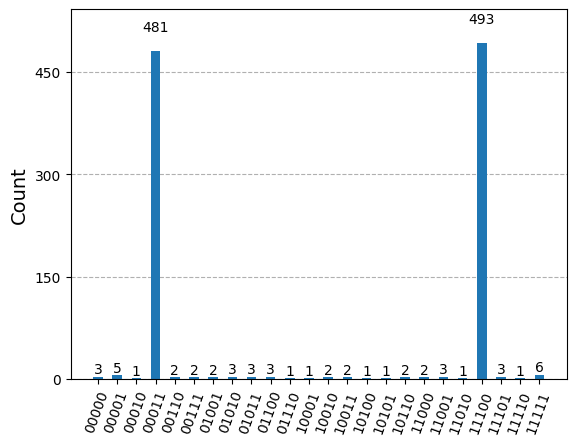

In [17]:
plot_histogram(counts)

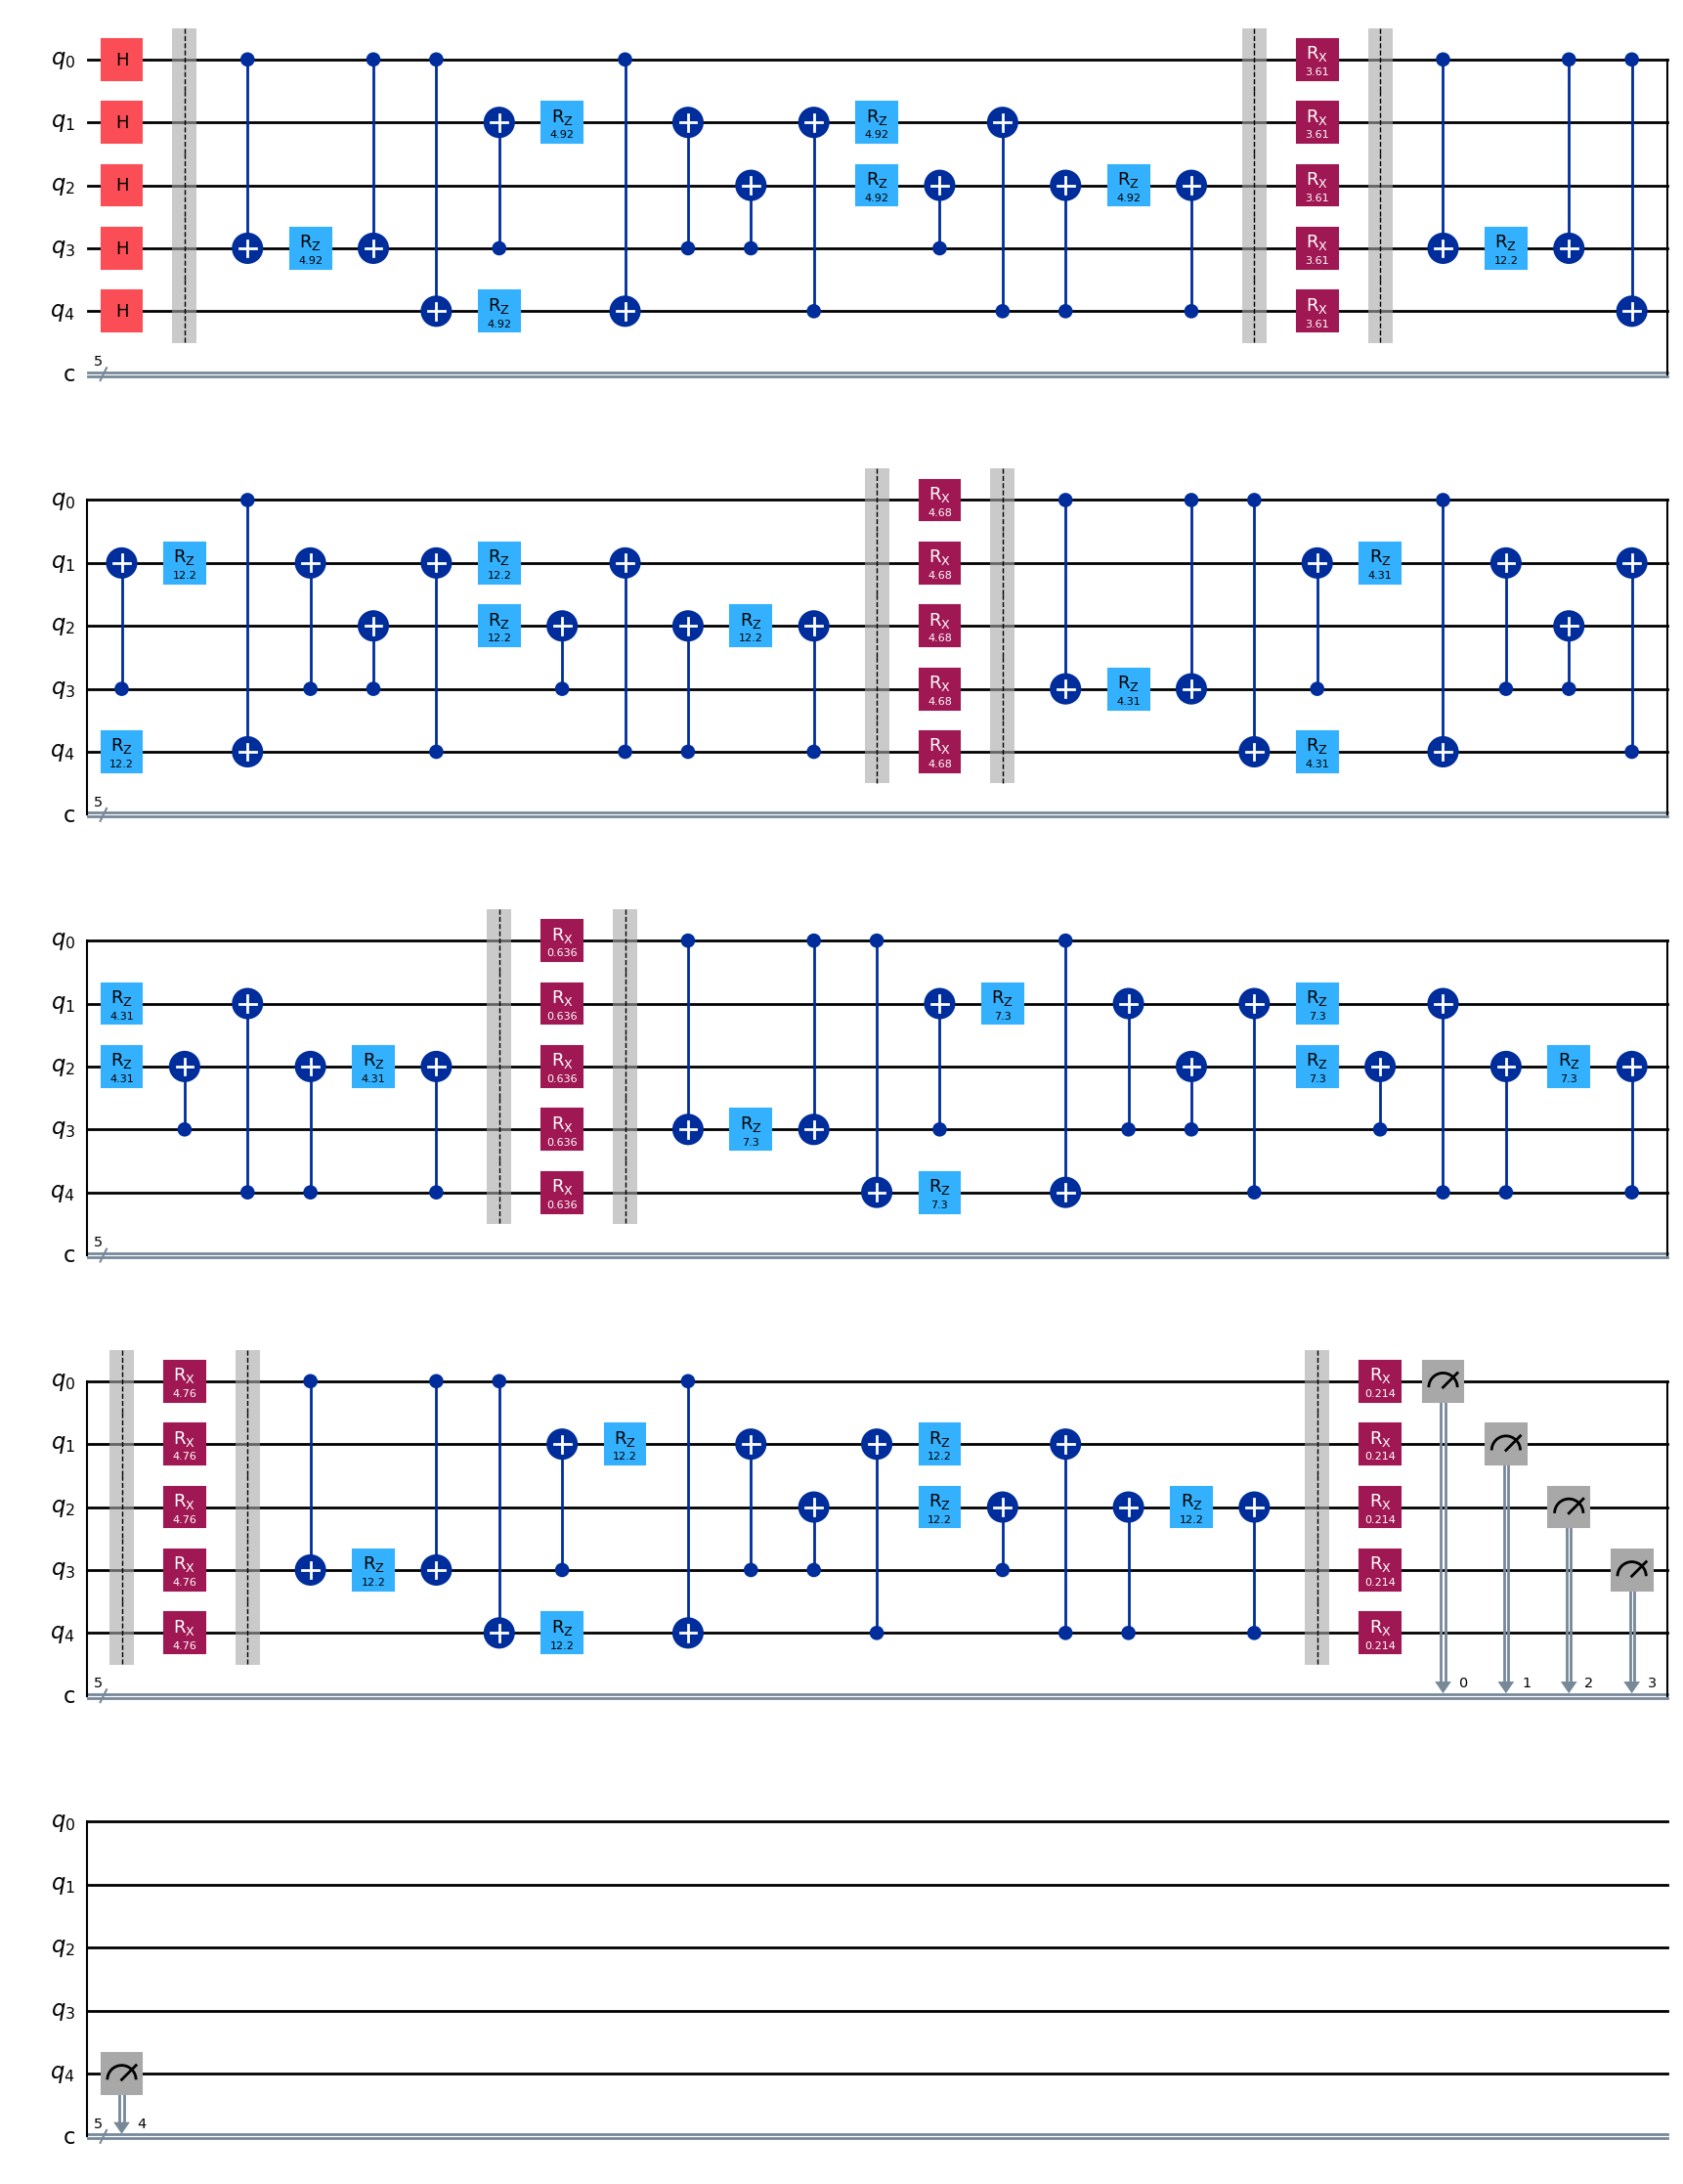

In [18]:
qc.draw(output='mpl')